In [62]:
#Loads all packages at beginning
import os
import shutil

import numpy as np
import pandas as pd
import pickle as pkl

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

import sys
import os
import getpass

import matplotlib.pyplot as plt
import networkx as nx
from sklearn.covariance import GraphicalLassoCV

import time
import scipy
from scipy import sparse

# Setup

In [4]:
username = getpass.getuser()
if username == 'mickey':
    data_directory = '/Volumes/Samsung_T5/aibs_data/example_ecephys_project_cache/'
    save_directory = '/Volumes/Samsung_T5/aibs_data/savedir/'
elif username == 'rahul':
    data_directory = 'D:\\OneDrive - UW\\research\\data@aibs' # must be updated to a valid directory in your filesystem
    save_directory = 'D:\\OneDrive - UW\\research\\data@aibs\\savedir'
elif username == 'Ryan':
    data_directory = 'C:\\Users\\Ryan\\Documents\\Grad School\\Research\\Eli\\Group\\Hack\\Allen_Data' # must be updated to a valid directory in your filesystem
    save_directory = 'C:\\Users\\Ryan\\Documents\\Grad School\\Research\\Eli\\Group\\Hack\\Save_Data'
elif username == 'chou':
    data_directory = '/Users/chou/Downloads/asdk-net-master'
    save_directory = '/Users/chou/Downloads/asdk-net-master'
    print('good')
    
manifest_path = os.path.join(data_directory, "manifest.json")

good


In [5]:
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

In [6]:
# sessions[sessions.session_type == 'functional_connectivity'].index

In [7]:
# Load Sessions and corresponding data
sessions = cache.get_session_table()
probes = cache.get_probes()
channels = cache.get_channels()
units = cache.get_units()


#print('Total number of sessions: ' + str(len(sessions)))
#sessions.head()

In [8]:
# sessions.ecephys_structure_acronyms.values[44]
# sessions[sessions.session_type == 'functional_connectivity'].index.size

## Function Definitions

In [9]:
class A_Config:
    def __init__(self, data_dir, save_dir, sess_id, stimulus):
        
        self.data_dir = data_dir 
        self.save_dir = save_dir
        self.sess_id = sess_id
        self.stimulus = stimulus

        self.name = os.path.join(self.save_dir,"ID{}_{}".format(self.sess_id, self.stimulus))

In [10]:
def save_Ps(cache,sess_id,stim_label_list,bin_size):
    data = cache.get_session_data(sess_id)
    #t_bin = {}
    #P = {}
    for i, stim_label in enumerate(stim_label_list):
        allencon = A_Config(data_directory,save_directory,sess_id,stim_label)
        print(i)
        # get start, end time points
        stim_data_table = data.get_stimulus_table()[data.get_stimulus_table().stimulus_name==stim_label]
        start_time = np.array(stim_data_table.start_time)
        stop_time = np.array(stim_data_table.stop_time)
        trial_time = np.mean(stop_time - start_time)
        bin_edges = np.arange(trial_time + bin_size, step = bin_size )
        t_bin = bin_edges
        print(i)
        stim_presentation_ids = data.stimulus_presentations.loc[
            (data.stimulus_presentations['stimulus_name'] == stim_label)
            ].index.values
        print(i)
        unit_ids = data.units.index.values
        print(i)
        P = data.presentationwise_spike_counts(bin_edges,stim_presentation_ids,unit_ids)/bin_size
        pkl.dump(P,open(allencon.name+'_bin_{}_P.p'.format(bin_size),'wb'))
        pkl.dump(t_bin,open(allencon.name+'_bin_{}_t.p'.format(bin_size),'wb'))

In [11]:
def plot_matrix(mat,motif,id):
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    norm = mpl.colors.Normalize(vmin=0.,vmax=np.max(mat))
    img=ax.matshow(mat,cmap='RdBu_r',norm=norm)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar_ax.tick_params(labelsize=20)
    fig.colorbar(img,cax=cbar_ax)
    ax.set_ylabel("Neuron index",fontsize=20)
    ax.set_xlabel("Neuron index",fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    fig.savefig(id+'_'+str(motif)+'.pdf',format='pdf',dpi=600)
    fig.savefig(id+'_'+str(motif)+'.png',format='png',dpi=600)

In [12]:
def smooth_spikes( P, kernel_width , bin_size ):
    # Rahul
    """
    P: #trials x #units x #time-points sized ndarray
    kernel_param: width of kernel (in samplingrate*1000 units)

    """

    import time
    import scipy.stats, scipy.signal
    import scipy as sp

    start = time.time() # tic Measures function running speed. Works only on Macs

    units = P.shape[0]
    trials = P.shape[1]
    bins = P.shape[2]

    # Create fake data for testing purposes
    #    array = np.random.randint(0,2,(trials,bins))
    #    sigma = 45

    #Define kernel
    kernel_param = kernel_width/bin_size
    sigma = kernel_param/6.
    edges = np.arange(-3*sigma,3*sigma+1,1)
    kernel = sp.stats.norm.pdf(edges,0, sigma) #Use a gaussian function
    kernel = kernel/sum(kernel)
    
    #Compute Spike Density Function for all trials
    #X = np.zeros((trials,units,bins))
    X = sp.signal.convolve(P, kernel[None,:, None], mode='same',method='direct')

    print('Run time for SDF function was ' + str(round(time.time()-start)) + 'seconds') # toc
    return X

## Run Calculations (Run for each stimulus/session)

In [97]:
sess_id=791319847
data = cache.get_session_data(sess_id)
stim_label_list = ['natural_scenes'] #All stimuli used
stim_label_list_idx = 0
stim_label = stim_label_list[stim_label_list_idx]

allencon = A_Config(data_directory,save_directory,sess_id,stim_label)
print(stim_label)
print(allencon.stimulus)

natural_scenes
natural_scenes


In [84]:
stims = data.get_stimulus_table()['stimulus_name']
s = []
for stim in stims:
    if stim not in s:
        s.append(stim)
print(s)

['spontaneous', 'gabors', 'flashes', 'drifting_gratings', 'natural_movie_three', 'natural_movie_one', 'static_gratings', 'natural_scenes', 'drifting_gratings_contrast']


In [85]:
#Bin & Kernel Parameters
bin_size=0.01
kernel_width=0.5

#kernel_param=kernel_width/bin_size

In [98]:
save_Ps(cache, sess_id, stim_label_list = [stim_label], bin_size=bin_size)

0
0
0
0


/Users/chou/opt/anaconda3/lib/python3.7/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:637: UserWarning: You've specified some overlapping time intervals between neighboring rows: [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (30, 31), (31, 32), (32, 33), (33, 34), (34, 35), (35, 36), (36, 37), (37, 38), (38, 39), (39, 40), (40, 41), (41, 42), (42, 43), (43, 44), (44, 45), (45, 46), (46, 47), (47, 48), (48, 49), (49, 50), (50, 51), (51, 52), (52, 53), (53, 54), (54, 55), (55, 56), (56, 57), (57, 58), (58, 59), (59, 60), (60, 61), (61, 62), (62, 63), (63, 64), (64, 65), (65, 66), (66, 67), (67, 68), (68, 69), (69, 70), (70, 71), (71, 72), (72, 73), (73, 74), (74, 75), (75, 76), (76, 77), (77, 78), (78, 79), (79, 80), (80, 81), (81, 82

In [99]:
X={}
for i, stim_label_ in enumerate([stim_label]):
    print(i)
    allencon = A_Config(data_directory,save_directory,sess_id,stim_label_)
    P = pkl.load(open(allencon.name+'_bin_{}_P.p'.format(bin_size),'rb'))
    X[stim_label] = smooth_spikes(P.values,kernel_width,bin_size)

0
Run time for SDF function was 121seconds


In [100]:
X[stim_label][:,:,:].shape

(5950, 26, 555)

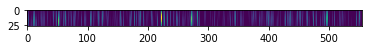

In [101]:
f = plt.figure()
# for p_idx, k in enumerate([0,9,19,29]):
#     ax = f.add_subplot(2,2,p_idx+1)
#     plt.plot(X[stim_label][0,:,k])
#     plt.xlabel('samples')
#     plt.ylabel('firing rate')
    
plt.imshow(X[stim_label][0,:,:])

In [102]:
n_trial = X[stim_label].shape[0]
n_time = X[stim_label].shape[1]
n_unit = X[stim_label].shape[2]
dither_noise = 0.1
adj_mats = []
unit_list = []
for k in range(1):
    print(k)
    t_ = time.time()
    units_to_use_idx_ = np.std(X[stim_label][k,:,:],axis=0)!=0
    model = GraphicalLassoCV()
    model.fit(X[stim_label][k,:,units_to_use_idx_].T)
    cov_ = model.covariance_
    prec_ = model.precision_
    adj_mats.append(prec_)
    unit_list.append(units_to_use_idx_)
    print('{}s'.format(time.time()-t_))

0


/Users/chou/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


41.09654188156128s


In [103]:
n_trials = len(adj_mats)
adj_x = np.zeros((n_trials, n_unit*n_unit))
for trial, mat in enumerate(adj_mats):
    a = unit_list[trial] * np.arange(1, len(unit_list[trial])+1)
    mask = np.ma.masked_equal(a,0)
    nz_idcs = mask.compressed() -1
    l_nz = len(nz_idcs)
    a_flat = adj_mats[trial].flatten()
    full_sparse = sparse.coo_matrix((a_flat, (np.repeat(nz_idcs, l_nz) , np.repeat(nz_idcs, l_nz))), shape=(n_unit, n_unit))
    full_adj = full_sparse.todense()
    adj_x[trial, :] = full_adj.flatten()
    print(l_nz)

376


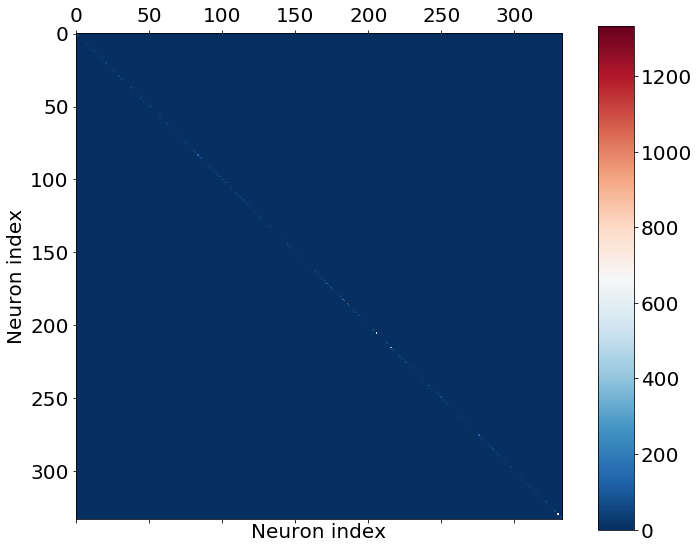

In [93]:

plot_matrix(100*np.abs(prec_),'{}_{}_trial{}'.format(sess_id,stim_label,0),'ggm')

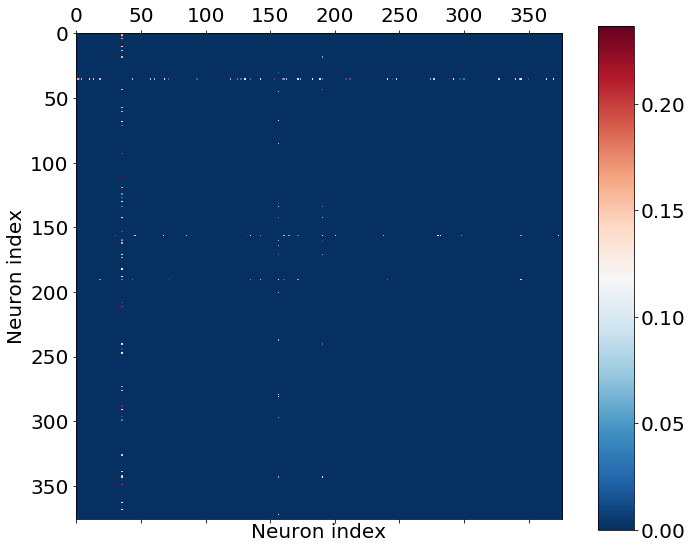

In [104]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mat = 100*np.abs(prec_)
mat = mat - np.diag(np.diag(mat))
motif = '{}_{}_trial{}'.format(sess_id,stim_label,0)
id = 'ggm'
A = 100*np.abs(prec_);
fig,ax = plt.subplots(1,1,figsize=(10,10))
norm = mpl.colors.Normalize(vmin=0.,vmax=np.max(mat))
img=ax.matshow(mat,cmap='RdBu_r',norm=norm)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar_ax.tick_params(labelsize=20)
fig.colorbar(img,cax=cbar_ax)
ax.set_ylabel("Neuron index",fontsize=20)
ax.set_xlabel("Neuron index",fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
fig.savefig(id+'_'+str(motif)+'.pdf',format='pdf',dpi=600)
fig.savefig(id+'_'+str(motif)+'.png',format='png',dpi=600)

In [72]:
X[stim_label][k,:,units_to_use_idx_].shape

(333, 26)

In [73]:
pkl.dump((adj_mats, unit_list), open(allencon.name + '_bin{}_adjmats.p'.format(bin_size), 'wb'))

In [ ]:
np.sum(full_adj - np.diag(np.diag(full_adj)))

In [ ]:
stim_label = ''

In [ ]:
allencon = A_Config(data.directory,save_directory,794812542,stim_label)

In [ ]:
adj_dgc = pkl.load(open(allencon.name + '_bin{}_adjmats_10.p'.format(bin_size), 'rb'))


# Additional Calculations/Methods

In [ ]:
X={}

In [ ]:
sum(P[stim_label].values)

In [ ]:
X[stim_label] = smooth_spikes(P[stim_label].values,kernel_param)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(X[stim_label][0,0,:])
plt.plot(X[stim_label][0,1,:])
plt.plot(X[stim_label][0,2,:])
plt.plot(X[stim_label][0,3,:])
plt.plot(X[stim_label][0,4,:])

In [ ]:
def load_sess_trials(cache, sess_id, stim_label_list, bin_size, kernel_width):
    # load session data
    data = cache.get_session_data(sess_id)
    t_bin = {}
    P = {}
    X = {}
    for i, stim_label in enumerate(stim_label_list):
        print(i)
        # get start, end time points
        stim_data_table = data.get_stimulus_table()[data.get_stimulus_table().stimulus_name==stim_label]
        start_time = np.array(stim_data_table.start_time)
        stop_time = np.array(stim_data_table.stop_time)
        trial_time = np.mean(stop_time - start_time)
        bin_edges = np.arange(trial_time + bin_size, step = bin_size )
        t_bin[stim_label] = bin_edges
        print(i)
        stim_presentation_ids = data.stimulus_presentations.loc[
            (data.stimulus_presentations['stimulus_name'] == stim_label)
            ].index.values
        print(i)
        unit_ids = data.units.index.values
        print(i)
        P[stim_label] = data.presentationwise_spike_counts(bin_edges,stim_presentation_ids,unit_ids)/bin_size
        print(i)
        # get windowed spike times
        # S[i] = window_spk_times(data,start_time,stop_time)
        # get binned spike rates
        # t_bin[i], P[i] = bin_spikes(S[i],bin_size)
        # kernel smoothed estimate of binned spike rates
        X[stim_label] = smooth_spikes(P[stim_label].values,kernel_width)
        
    return (t_bin, P, X)

In [ ]:
import numpy as np
import pandas as pd

data = cache.get_session_data(sess_id)
t_bin = {}
#P = {}
for i, stim_label in enumerate(stim_label_list):
    allencon = A_Config(data_directory,save_directory,sess_id,stim_label)
    print(i)
    # get start, end time points
    stim_data_table = data.get_stimulus_table()[data.get_stimulus_table().stimulus_name==stim_label]
    start_time = np.array(stim_data_table.start_time)
    stop_time = np.array(stim_data_table.stop_time)
    trial_time = np.mean(stop_time - start_time)
    bin_edges = np.arange(trial_time + bin_size, step = bin_size )
    t_bin[stim_label] = bin_edges
    print(i)
    stim_presentation_ids = data.stimulus_presentations.loc[
        (data.stimulus_presentations['stimulus_name'] == stim_label)
        ].index.values
    print(i)
    unit_ids = data.units.index.values
    print(i)
    P = data.presentationwise_spike_counts(bin_edges,stim_presentation_ids,unit_ids)/bin_size
    pkl.dump(P,open(allencon.name+'_bin_{}_P.p'.format(bin_size),'wb'))
    print(i)
    # get windowed spike times
    # S[i] = window_spk_times(data,start_time,stop_time)
    # get binned spike rates
    # t_bin[i], P[i] = bin_spikes(S[i],bin_size)
    # kernel smoothed estimate of binned spike rates


In [ ]:
P=pkl.load(open(allencon.name+'_bin_{}_P.p'.format(bin_size),'rb'))
X = smooth_spikes(P.values,kernel_width=0.1, bin_size= 0.01)

In [ ]:
X[0,:,:]

In [ ]:
t_bin,P,X = load_sess_trials(cache, 794812542, stim_label_list = ['drifting_gratings_contrast'], bin_size=0.01, kernel_param=0.1)

In [ ]:
dir()

In [ ]:
data_dg=data.get_stimulus_table()[data.get_stimulus_table().stimulus_name=='drifting_gratings_contrast']

In [ ]:
data_dg

In [ ]:
data.spike_times

In [ ]:
data.units.index

In [ ]:
data.spike_times[data.units.index[0]]

In [ ]:
unit_spikes=data.spike_times[data.units.index[0]]

In [ ]:
unit_spikes[np.logical_and(unit_spikes>=data_dg.start_time.values[0],unit_spikes<data_dg.start_time.values[1])]

In [ ]:
def smooth_spikes( P, kernel_width , bin_size ):
    # Rahul
    """
    P: #trials x #units x #time-points sized ndarray
    kernel_param: width of kernel (in samplingrate*1000 units)

    """

    import time
    import scipy.stats, scipy.signal
    import scipy as sp

    start = time.time() # tic Measures function running speed. Works only on Macs

    trials = P.shape[0]
    units = P.shape[1]
    bins = P.shape[2]

    # Create fake data for testing purposes
    #    array = np.random.randint(0,2,(trials,bins))
    #    sigma = 45

    #Define kernel
    kernel_param = kernel_width/bin_size
    sigma = kernel_param/6.
    edges = np.arange(-3*sigma,3*sigma+1,1)
    kernel = sp.stats.norm.pdf(edges,0, sigma) #Use a gaussian function
    kernel = kernel/sum(kernel)
    
    #Compute Spike Density Function for all trials
    #X = np.zeros((trials,units,bins))
    X = sp.signal.convolve(P, kernel[None,None, :], mode='same',method='direct')

    print('Run time for SDF function was ' + str(round(time.time()-start)) + 'seconds') # toc
    return X

In [ ]:
import scipy as sp

In [ ]:
kernel_width = 0.01
sigma = kernel_width/6.
edges = np.arange(-3*sigma,3*sigma+.001,.001)
kernel = sp.stats.norm.pdf(edges,0, sigma) #Use a gaussian function

In [ ]:
kernel_width = .5
bin_size = .001
kernel_param = kernel_width/bin_size
sigma = kernel_param/6.
edges = np.arange(-3*sigma,3*sigma+1,1)
kernel = sp.stats.norm.pdf(edges,0, sigma) #Use a gaussian function
kernel = kernel/sum(kernel)

In [ ]:
plt.plot(edges,kernel/sum(kernel))
print(sum(kernel))

In [ ]:
sum(kernel)

In [ ]:
def est_frate(P_stim, k_p):
    """
    P_stim: #trials x #units x #time-points sized ndarray
    k_p: width of kernel (in samplingrate*1000 units)

    """

    import numpy as np
    import time
    import scipy.stats, scipy.signal
    import scipy as sp

    start = time.time() # tic Measures function running speed. Works only on Macs

    trials = P_stim.shape[0]
    units = P_stim.shape[1]
    bins = P_stim.shape[2]

    # Create fake data for testing purposes
    #    array = np.random.randint(0,2,(trials,bins))
    #    sigma = 45

    #Define kernel
    sigma = k_p/6. 
    edges = np.arange(-3*sigma,3*sigma+.001,.001)
    kernel = sp.stats.norm.pdf(edges,0, sigma) #Use a gaussian function

    #Compute Spike Density Function for all trials
    Sdf = np.zeros((trials,units,bins))
    Sdf = sp.signal.convolve(P_stim, kernel[None,None, :], mode='same',method='direct')

    print('Run time for SDF function was ' + str(round(time.time()-start)) + 'seconds') # toc

    return Sdf

In [ ]:
P_stim = np.random.rand(3,5,100)

In [ ]:
P_stim

In [ ]:
X_stim=est_frate(P_stim,0.01)

In [ ]:
X_stim

In [ ]:
plt.plot

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(P_stim[0,0,:])


In [ ]:
plt.plot(X_stim[0,0,:])

In [ ]:
plt.plot(P_stim[0,1,:])

In [ ]:
plt.plot(X_stim[0,1,:])

In [ ]:
plt.plot(P_stim[1,1,:])

In [ ]:
plt.plot(X_stim[1,1,:])

In [ ]:
import numpy as np
import pandas as pd
import pickle as pkl

def save_Ps(cache,sess_id,stim_label_list,bin_size):
    data = cache.get_session_data(sess_id)
    #t_bin = {}
    #P = {}
    for i, stim_label in enumerate(stim_label_list):
        allencon = A_Config(data_directory,save_directory,sess_id,stim_label)
        print(i)
        # get start, end time points
        stim_data_table = data.get_stimulus_table()[data.get_stimulus_table().stimulus_name==stim_label]
        start_time = np.array(stim_data_table.start_time)
        stop_time = np.array(stim_data_table.stop_time)
        trial_time = np.mean(stop_time - start_time)
        bin_edges = np.arange(trial_time + bin_size, step = bin_size )
        t_bin = bin_edges
        print(i)
        stim_presentation_ids = data.stimulus_presentations.loc[
            (data.stimulus_presentations['stimulus_name'] == stim_label)
            ].index.values
        print(i)
        unit_ids = data.units.index.values
        print(i)
        P = data.presentationwise_spike_counts(bin_edges,stim_presentation_ids,unit_ids)/bin_size
        pkl.dump(P,open(allencon.name+'_bin_{}_P.p'.format(bin_size),'wb'))
        pkl.dump(t_bin,open(allencon.name+'_bin_{}_t.p'.format(bin_size),'wb'))